In [28]:
from copy import copy
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights
from torchvision.models import resnet18
import cv2
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

In [29]:
import warnings
warnings.filterwarnings("ignore")

### Исправить
1. +*Датасет  (imageFolder)*
2. +*Отдельный класс для модели*
3. +*Разделить train loop на функции*
4. +*Метрики из sklearn*

In [30]:
train_data_path = 'data/train'
test_data_path = 'data/test'

In [31]:
hotdog_path = os.path.join(train_data_path, 'hotdog')
not_hotdog_path = os.path.join(train_data_path, 'nothotdog')

In [32]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Resize(256),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.ColorJitter(brightness=0.05, hue=0.3),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Resize(256),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [33]:
'''class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.dataset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            return self.transform(x), y
        return x, y

    def __len__(self):
        return len(self.dataset)'''

'class DatasetFromSubset(Dataset):\n    def __init__(self, subset, transform=None):\n        self.dataset = subset\n        self.transform = transform\n\n    def __getitem__(self, index):\n        x, y = self.dataset[index]\n        if self.transform:\n            return self.transform(x), y\n        return x, y\n\n    def __len__(self):\n        return len(self.dataset)'

In [34]:
full_train_dataset = ImageFolder(root=train_data_path, transform=transform_train)
train_dataset, val_dataset = random_split(full_train_dataset, [0.8, 0.2])
train_dataset.dataset = copy(full_train_dataset)
val_dataset.dataset.transform = transform_val
train_dataset.dataset.transform = transform_train
#train_dataset = DatasetFromSubset(train_dataset, transform=transform_train)
#val_dataset = DatasetFromSubset(val_dataset, transform=transform_val)

In [35]:
print(train_dataset.dataset.transform, '\n', val_dataset.dataset.transform)

Compose(
    ToTensor()
    ConvertImageDtype()
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
) 
 Compose(
    ToTensor()
    ConvertImageDtype()
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [36]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [37]:
print(len(train_dataset), len(val_dataset))
print(len(train_loader), len(val_loader))

2400 600
75 19


!!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


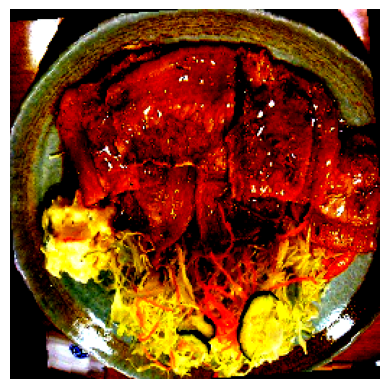

tensor(1)


In [38]:
i = 0
for i in range(1):
    print('!!!')
    j = 0
    for images, label in train_loader:
        first_image = images[0].numpy()
        plt.imshow(np.transpose(first_image, (1, 2, 0)))
        plt.axis('off')
        plt.show()
        print(label[0])
        if j >= 0:
            break
        j += 1

In [39]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT) #Pretrained ResNet18
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2) #Changing the number of outputs to 2
    def forward(self, x):
        return self.resnet(x)

In [40]:
model = CustomModel()

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

'cuda:0'

In [41]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9) #Adam showed worse metrics by about 0.1
criterion = nn.CrossEntropyLoss()
epochs = 150

# Model training

In [42]:
def train_one_epoch():
    train_loss_run = 0.0
    for images, labels in train_loader:
        torch.cuda.empty_cache()
        images.to(device)
        labels.to(device)
        if device == 'cuda:0':
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels.long())
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        train_loss_run += loss.item()
    return train_loss_run  

def val_one_epoch(e, train_loss_run):
    sum_of_accuracy, sum_of_precision, sum_of_recall, sum_of_f1_score = 0.0, 0.0, 0.0, 0.0
    val_loss_run = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            torch.cuda.empty_cache()
            images.to(device)
            labels.to(device)
            if device == 'cuda:0':
                images, labels = images.cuda(), labels.cuda()
            output = model(images)
            loss = criterion(output, labels.long())
            _, predicted = torch.max(output, 1)

            accuracy = accuracy_score(labels.cpu(), predicted.cpu())
            precision = precision_score(labels.cpu(), predicted.cpu())
            recall = recall_score(labels.cpu(), predicted.cpu())
            f1_score = 2 * ((precision * recall) / (precision + recall))
        
            sum_of_accuracy += accuracy
            sum_of_precision += precision
            sum_of_recall += recall
            sum_of_f1_score += f1_score
            val_loss_run += loss.item()

        avg_accuracy = sum_of_accuracy / len(val_loader)
        avg_precision = sum_of_precision / len(val_loader)
        avg_recall = sum_of_recall / len(val_loader)
        avg_f1 = sum_of_f1_score / len(val_loader)
        val_loss = val_loss_run / len(train_loader)
        train_loss = train_loss_run / len(train_loader)

        print(f'\nEpoch: {e+1}, Train_loss: {train_loss}, Val_loss: {val_loss}, Accuracy: {avg_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}, F1-score: {avg_f1}')
        return train_loss, val_loss

### Train loop

In [43]:
loss_val_arr = []
loss_train_arr = []
torch.cuda.empty_cache()
counter = 0
early_stop = 20
best_val_loss = 1000000.0
for e in range(epochs):
    model.train()
    train_loss_run = train_one_epoch()

    model.eval()
    train_loss, val_loss = val_one_epoch(e, train_loss_run)

    loss_val_arr.append(val_loss)
    loss_train_arr.append(train_loss)
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'checkpoint.pth')
        continue
    else:
        counter += 1
        if counter >= early_stop:
            print(f'\nEarly stop on {e} epoch, best val loss: {best_val_loss}')
            break
model.load_state_dict(torch.load('checkpoint.pth'))


Epoch: 1, Train_loss: 0.42990161617596945, Val_loss: 0.05852012058099111, Accuracy: 0.9150219298245614, Precision: 0.9353750858252244, Recall: 0.8947616968514803, F1-score: 0.9123968979582048

Epoch: 2, Train_loss: 0.24279229899247487, Val_loss: 0.051425979634126026, Accuracy: 0.9276315789473685, Precision: 0.96068257078319, Recall: 0.8947440567959553, F1-score: 0.9246633103546826

Epoch: 3, Train_loss: 0.20459672609965007, Val_loss: 0.04510702376564344, Accuracy: 0.9342105263157895, Precision: 0.9585004177109442, Recall: 0.9020713076053635, F1-score: 0.926141437197542

Epoch: 4, Train_loss: 0.16718501562873522, Val_loss: 0.04109829609592756, Accuracy: 0.9342105263157895, Precision: 0.9296785249042053, Recall: 0.9268042770059227, F1-score: 0.9262554956049818

Epoch: 5, Train_loss: 0.15127521033088367, Val_loss: 0.04048736912508805, Accuracy: 0.9298245614035089, Precision: 0.8987105293489059, Recall: 0.9580137022555958, F1-score: 0.9260047397393845

Epoch: 6, Train_loss: 0.141933836340

<All keys matched successfully>

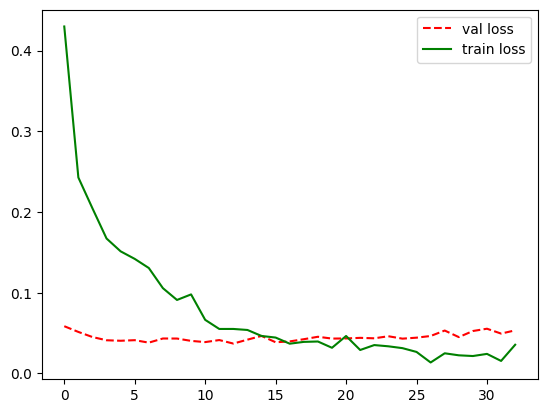

In [44]:
#Graphs of loss function changes
plt.plot(loss_val_arr, "r--", label="val loss")
plt.plot(loss_train_arr, "g", label="train loss")
plt.legend()
plt.show()

In [45]:
torch.save(model.state_dict(), 'hotdogs_resnet18_SGD_earlystop.pth')

# Model testing

In [46]:
test_data = ImageFolder(root=test_data_path, transform=transform_val)

In [47]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [48]:
model.eval()
sum_of_accuracy, sum_of_precision, sum_of_recall, sum_of_f1_score = 0.0, 0.0, 0.0, 0.0
with torch.no_grad():
    for images, labels in test_loader:
        torch.cuda.empty_cache()
        images.to(device)
        labels.to(device)
        if device == 'cuda:0':
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels.long())
        _, predicted = torch.max(output, 1)

        accuracy = accuracy_score(labels.cpu(), predicted.cpu())
        precision = precision_score(labels.cpu(), predicted.cpu())
        recall = recall_score(labels.cpu(), predicted.cpu())
        f1_score = 2 * ((precision * recall) / (precision + recall))

        print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1_score}')      

        sum_of_accuracy += accuracy
        sum_of_precision += precision
        sum_of_recall += recall
        sum_of_f1_score += f1_score

    avg_accuracy = sum_of_accuracy / len(test_loader)
    avg_precision = sum_of_precision / len(test_loader)
    avg_recall = sum_of_recall / len(test_loader)
    avg_f1 = sum_of_f1_score / len(test_loader)

    print(f'\n\nAverage Accuracy: {avg_accuracy}, Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-score: {avg_f1}')

Accuracy: 0.875, Precision: 0.9285714285714286, Recall: 0.8125, F1-score: 0.8666666666666666
Accuracy: 0.9375, Precision: 0.8947368421052632, Recall: 1.0, F1-score: 0.9444444444444444
Accuracy: 0.96875, Precision: 1.0, Recall: 0.9444444444444444, F1-score: 0.9714285714285714
Accuracy: 0.96875, Precision: 0.9444444444444444, Recall: 1.0, F1-score: 0.9714285714285714
Accuracy: 0.9375, Precision: 0.9375, Recall: 0.9375, F1-score: 0.9375
Accuracy: 0.9375, Precision: 1.0, Recall: 0.8947368421052632, F1-score: 0.9444444444444444
Accuracy: 0.9375, Precision: 0.9333333333333333, Recall: 0.9333333333333333, F1-score: 0.9333333333333333
Accuracy: 0.9375, Precision: 0.9411764705882353, Recall: 0.9411764705882353, F1-score: 0.9411764705882353
Accuracy: 0.875, Precision: 0.8333333333333334, Recall: 0.8333333333333334, F1-score: 0.8333333333333334
Accuracy: 0.9375, Precision: 0.9444444444444444, Recall: 0.9444444444444444, F1-score: 0.9444444444444444
Accuracy: 0.96875, Precision: 0.9333333333333333